# Imports

In [ ]:
import math
import json
import requests
import numpy as np
import pandas as pd
pd.set_option('max_rows', None)

from google.colab import drive
drive.mount('/content/drive')

from google.colab import auth
auth.authenticate_user()

import gspread
from gspread_dataframe import set_with_dataframe
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

allow_runall = False

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Votes

In [ ]:
default_delimiter = ". "
special_delimiters = ["\) "]

In [ ]:
votesheet = gc.open('2000s Movies').worksheet('Votes')
votes = np.array(votesheet.get_all_values())

chartsheet = gc.open('2000s Movies').worksheet('Chart')

dictsheet = gc.open('2000s Movies').worksheet('Dict')

In [ ]:
votes_df = pd.DataFrame(votes[1:,:], columns=votes[0], index=range(1,len(votes[:,0])))

# Tag unranked votes
for voter in votes_df:
  votes_df[voter] = votes_df[voter].mask(votes_df[voter].str.startswith("["), "-1. " + votes_df[voter].astype(str))
  
  #remove comments after ]
  #votes_df[voter] = votes_df[voter].str.split("]", expand=True) + "]"
  votes_df[voter] = votes_df[voter].str.split("]", n=1, expand=True) + "]"

# Replace non-default delimiters
for sd in special_delimiters:
  votes_df.replace(sd, default_delimiter, regex=True, inplace=True)

votes_df.mask(votes_df=="]","0",inplace=True)
votes_df.head()

,AinsleyIscariot,Allyn,amanda_online,Aruji,astadaradim,avalyn2,Bach,Blazko,BeepisBoopis,BlueSkies,bobohead61x,carlitos_go,Celebros,Cicadidae,comrade_sue,connordenney,crushedtoapulp,Cubbierill,darsu,DeathOfSeasons,Dew1400,diction,Dolwphin,DtzaraD,dukkha,Faure,goodsinginggum,Havey,hollowchatter,Inovox,Iron_Dwarf,Jabbi,Jag114,JessieEye,JoLeKosovo,Josh318,jpzitoleopold,KnightToMourning,LifeDuringWartime,LowFidelity,MicrophoneFiend,momotaroyouth,moorezy,mrblond,mistercb,nadenrhys,nostalghia,nervalitis,NeverTrump,nivekwriter,novocaine69,Ohg,oscarmurraey,Ovals,peelsa,Rehtek,Rengar18,russalex86,RuthJanelle,sesherhesher,Silverblack,she_esh,simo000,Sluggo714,spencership,Stoicorum,Strawhenge,SynysterShadows,tectactoe,thefeverayeaye,tonkatonka,tuukkis,YasashiiDia
1,1. [Film1870],01. [Film27],01. [Film50],1. [Film2721],1. [Film50],1. [Film1441],1. [Film178],1. [Film2328],1. [Film3613],-1. [Film50],1. [Film1441],1. [Film333],1. [Film2635],1. [Film16833],1. [Film639],01. [Film7747],01. [Film50],1. [Film178],1. [Film4262],1. [Film49540],1. [Film92736],1. [Film1164],1. [Film19683],1. [Film2338],1. [Film18655],01. [Film288],1. [Film1870],1. [Film18655],01. [Film1491],1. [Film639],1. [Film1441],1. [Film93],01. [Film1511],1. [Film1164],1. [Film2721],1. [Film1208],1. [Film678],1. [Film180],1. [Film19083],1. [Film812],1. [Film639],1. [Film8],1. [Film68],1. [Film1386],01. [Film205],1. [Film1491],1. [Film678],1. [Film6376],01. [Film768],1. [Film470],1. [Film782],1. [Film18655],1. [Film19683],1. [Film18971],1. [Film19683],1. [Film2721],1. [Film1001],1. [Film2338],1. [Film68],1. [Film50],1. [Film50],1. [Film7747],1. [Film49540],1. [Film639],1. [Film68],1. [Film1870],1. [Film59],-1. [Film150],1. [Film6208],1. [Film288],1. [Film4859],1. [Film639],1. [Film639]
2,2. [Film227],02. [Film1334],02. [Film23474],2. [Film180],2. [Film8061],2. [Film1164],2. [Film532],2. [Film27],2. [Film1035],-1. [Film288],2. [Film639],2. [Film7679],2. [Film1223],2. [Film1223],2. [Film10718],02. [Film8040],02. [Film1164],2. [Film55416],2. [Film1164],2. [Film55292],2. [Film227],2. [Film4913],2. [Film1234],2. [Film671],2. [Film1939],02. [Film678],2. [Film1374],2. [Film1234],02. [Film18655],2. [Film205],2. [Film91],2. [Film2721],02. [Film11787],2. [Film1441],2. [Film683],2. [Film455],2. [Film4117],2. [Film255],2. [Film7186],2. [Film327],2. [Film98],2. [Film227],2. [Film1441],2. [Film554],02. [Film207],2. [Film5529],2. [Film6374],2. [Film24262],02. [Film2338],2. [Film107],2. [Film153],2. [Film288],2. [Film18655],2. [Film678],2. [Film18655],2. [Film2574],2. [Film288],2. [Film288],2. [Film470],2. [Film343],2. [Film639],2. [Film68],2. [Film639],2. [Film632],2. [Film710],2. [Film68],2. [Film68],-1. [Film338],2. [Film371],2. [Film1208],2. [Film8034],2. [Film1431],2. [Film288]
3,3. [Film1223],03. [Film2721],03. [Film726],3. [Film768],3. [Film288],3. [Film98],3. [Film5331],3. [Film1193],3. [Film1230],-1. [Film2929],3. [Film1164],3. [Film11785],3. [Film27375],3. [Film768],3. [Film302],03. [Film59635],03. [Film3473],3. [Film288],3. [Film1562],3. [Film1223],3. [Film1223],3. [Film325],3. [Film1441],3. [Film1449],3. [Film27375],03. [Film639],3. [Film6461],3. [Film2642],03. [Film50],3. [Film13597],3. [Film1857],3. [Film11789],03. [Film3745],3. [Film6461],3. [Film38416],3. [Film68],3. [Film2338],3. [Film512],3. [Film20912],3. [Film8094],3. [Film280],3. [Film1449],3. [Film2125],3. [Film632],03. [Film1223],3. [Film1219],3. [Film643],3. [Film1001],03. [Film57],3. [Film989],3. [Film330],3. [Film1858],3. [Film1870],3. [Film726],3. [Film768],3. [Film227],3. [Film639],3. [Film1562],3. [Film20912],3. [Film1001],3. [Film1164],3. [Film1164],3. [Film2721],3. [Film1441],3. [Film50],3. [Film276],3. [Film113],-1. [Film1062],3. [Film1355],3. [Film15214],3. [Film2338],3. [Film114294],3. [Film1556]
4,4. [Film4172],04. [Film20087],04. [Film678],4. [Film288],4. [Film153],4. [Film27],4. [Film1811],4. [Film1250],4. [Film1805],-1. [Film2338],4. [Film1574],4. [Film153],4. [Film8],4. [Film574],4. [Film10567],04. [Film288]

In [ ]:
titles = votes_df.applymap(lambda x: x.split(". ", 1)[-1]).to_numpy().flatten()
titles = np.unique(titles)
vote_matrix = pd.DataFrame(index=titles, columns = votes_df.columns)
print(vote_matrix.shape)

(1029, 73)


In [ ]:
vote_matrix = pd.DataFrame()

for voter in votes_df:
  for i, vote in enumerate(votes_df[voter]):
    if vote == "": break
    try: rank, title = vote.split(". ", 1)
    except ValueError: 
      rank, title = i+1, vote.split(". ", 1)[-1]
    vote_matrix.loc[title, voter] = rank

vote_matrix.fillna(0,inplace=True)
vote_matrix = vote_matrix.astype(pd.SparseDtype("int", 0))
vote_matrix = vote_matrix.drop(["0"])
print('Density:', vote_matrix.sparse.density, '\nvote_matrix.shape', vote_matrix.shape)
display(vote_matrix.head())

Density: 0.04334790256382922 
vote_matrix.shape (1028, 73)


,AinsleyIscariot,Allyn,amanda_online,Aruji,astadaradim,avalyn2,Bach,Blazko,BeepisBoopis,BlueSkies,bobohead61x,carlitos_go,Celebros,Cicadidae,comrade_sue,connordenney,crushedtoapulp,Cubbierill,darsu,DeathOfSeasons,Dew1400,diction,Dolwphin,DtzaraD,dukkha,Faure,goodsinginggum,Havey,hollowchatter,Inovox,Iron_Dwarf,Jabbi,Jag114,JessieEye,JoLeKosovo,Josh318,jpzitoleopold,KnightToMourning,LifeDuringWartime,LowFidelity,MicrophoneFiend,momotaroyouth,moorezy,mrblond,mistercb,nadenrhys,nostalghia,nervalitis,NeverTrump,nivekwriter,novocaine69,Ohg,oscarmurraey,Ovals,peelsa,Rehtek,Rengar18,russalex86,RuthJanelle,sesherhesher,Silverblack,she_esh,simo000,Sluggo714,spencership,Stoicorum,Strawhenge,SynysterShadows,tectactoe,thefeverayeaye,tonkatonka,tuukkis,YasashiiDia
[Film1870],1,0,0,44,21,0,0,0,0,0,0,0,0,22,0,0,46,4,12,0,50,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,16,0,7,0,0,0,0,0,0,16,0,0,3,0,0,0,0,21,0,0,18,45,0,0,0,1,0,0,0,21,0,0,0
[Film227],2,42,0,0,13,0,12,0,0,0,0,0,0,44,20,0,15,0,0,0,2,0,0,0,0,0,0,0,20,0,0,0,0,0,0,0,0,0,0,0,36,2,8,0,20,0,0,0,31,40,24,0,40,0,0,3,0,22,49,0,5,0,0,0,38,0,0,0,0,0,0,0,0
[Film1223],3,0,0,0,0,0,0,0,0,0,0,0,2,2,0,0,6,0,5,3,3,0,0,0,16,0,0,14,30,0,0,0,0,0,0,0,45,0,0,0,0,31,0,0,3,0,0,0,4,0,0,0,10,46,9,0,0,0,0,0,0,25,0,0,0,0,0,0,0,26,26,0,0
[Film4172],4,0,0,0,0,0,0,0,0,0,40,0,0,0,0,0,0,0,33,4,0,0,0,0,0,0,0,0,0,0,0,0,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,41,0,0,0,0,42,0,0,0,0,0,0,0
[Film9208],5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Number of ranked votes
ranked_votes = [max(max(vote_matrix[vote_matrix[col].notna()][col]),0) for col in vote_matrix.columns]

# Number of unranked votes
unranked_votes = [vote_matrix[vote_matrix[col]==-1][col].count() for col in vote_matrix.columns]

# Total votes
from operator import add
total_votes= list(map(add, ranked_votes, unranked_votes))

vm_index = ['ranked_votes','unranked_votes', 'total_votes']
vm_data = [ranked_votes, unranked_votes, total_votes]

vmdf = pd.DataFrame(vm_data, columns=vote_matrix.columns, index=vm_index)
vmdf

,AinsleyIscariot,Allyn,amanda_online,Aruji,astadaradim,avalyn2,Bach,Blazko,BeepisBoopis,BlueSkies,bobohead61x,carlitos_go,Celebros,Cicadidae,comrade_sue,connordenney,crushedtoapulp,Cubbierill,darsu,DeathOfSeasons,Dew1400,diction,Dolwphin,DtzaraD,dukkha,Faure,goodsinginggum,Havey,hollowchatter,Inovox,Iron_Dwarf,Jabbi,Jag114,JessieEye,JoLeKosovo,Josh318,jpzitoleopold,KnightToMourning,LifeDuringWartime,LowFidelity,MicrophoneFiend,momotaroyouth,moorezy,mrblond,mistercb,nadenrhys,nostalghia,nervalitis,NeverTrump,nivekwriter,novocaine69,Ohg,oscarmurraey,Ovals,peelsa,Rehtek,Rengar18,russalex86,RuthJanelle,sesherhesher,Silverblack,she_esh,simo000,Sluggo714,spencership,Stoicorum,Strawhenge,SynysterShadows,tectactoe,thefeverayeaye,tonkatonka,tuukkis,YasashiiDia
ranked_votes,50,50,20,50,50,50,50,50,21,0,50,50,50,50,50,50,50,50,50,50,50,50,40,50,50,50,50,20,50,5,20,33,50,50,15,50,50,20,50,10,50,50,50,50,50,10,50,30,50,50,50,10,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,0,50,50,50,50,50
unranked_votes,0,0,0,0,0,0,0,0,0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50,0,0,0,0,0
total_votes,50,50,20,50,50,50,50,50,21,50,50,50,50,50,50,50,50,50,50,50,50,50,40,50,50,50,50,20,50,5,20,33,50,50,15,50,50,20,50,10,50,50,50,50,50,10,50,30,50,50,50,10,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50


In [ ]:
# Count votes per title
counts = vote_matrix.astype(bool).sum(axis=1)
cdf = pd.DataFrame(index=vote_matrix.index)
cdf['Votes'] = counts.values

# Modified Borda count
cdf['PopScore'], cdf['Score'] = 0, 0
cdf['Esoteric\nScore'] = 0

cdf['Gold\nMedals'] = 0 # Number of top spots

most_votes = max(cdf['Votes'])
weight = 7
inv_pop_weight = 0.15

for title in cdf.index:
    
    points,esoteric,goldmedals = 0,0,0
    votes = cdf.loc[title,'Votes'] 

    if votes < 1:
        cdf.loc[title,'Score'] = 0
        cdf.loc[title,'Esoteric\nScore'] = 0
        continue
    
    for voter in vote_matrix.columns:
        
        total_votes = vmdf.loc['total_votes',voter]
        ranked_votes = vmdf.loc['ranked_votes',voter]
        rank = vote_matrix.loc[title,voter]
        
        if rank > 0: # Ranked votes
            points += total_votes + 1 - rank
            esoteric += 1 + (total_votes-1)*np.exp(-(rank-1)**2 / (2*weight**2))
            if rank == 1: goldmedals += 1
            
        elif rank == -1: # Unranked votes
            points += 0.5 * (1+total_votes-ranked_votes)
            esoteric += 1
    
    cdf.loc[title,'Score'] = points
    cdf.loc[title,'Gold\nMedals'] = goldmedals
    
    esoteric *= 1 + most_votes * np.exp(-(votes-1)**2 / (2*(inv_pop_weight*most_votes)**2))
    esoteric /= 1 + most_votes
    cdf.loc[title,'Esoteric\nScore'] = esoteric
    
cdf['PopScore'] += cdf['Score']*cdf['Votes']
cdf['Score'] += 0.0001*cdf['Votes'] # hacky way of sorting ties by votes for ranking

In [ ]:
cdf['Rank'] = cdf['Score'].rank(ascending=False,method='min').astype(int)
cdf['PopRank'] = cdf['PopScore'].rank(ascending=False,method='min').astype(int)
cdf['Score'] = cdf['Score'].round(1)
cdf['Esoteric\nScore'] = cdf['Esoteric\nScore'].round(1)
cdf['Esoteric\nRank'] = cdf['Esoteric\nScore'].rank(ascending=False,method='min').astype(int)
cdf['Gold\nRank'] = cdf['Gold\nMedals'].rank(ascending=False,method='min').astype(int)
cdf.loc[cdf['Score']<1,'Votes'] = 0

cdf["UniqueScore"] = cdf["Score"].where(cdf["Votes"]==1,0)
cdf["UniqueRank"] = cdf["UniqueScore"].rank(ascending=False,method='min').astype(int)

cdf.sort_values(by=['Rank']).head(5)

,Votes,PopScore,Score,Esoteric\nScore,Gold\nMedals,Rank,PopRank,Esoteric\nRank,Gold\nRank,UniqueScore,UniqueRank
[Film288],51,95548.5,1873.5,26.5,2,1,1,223,9,0.0,554
[Film1441],35,40495.0,1157.0,13.8,3,2,2,334,3,0.0,554
[Film639],34,39253.0,1154.5,15.8,6,3,3,311,1,0.0,554
[Film68],30,32205.0,1073.5,13.5,3,4,4,338,3,0.0,554
[Film1164],28,28602.0,1021.5,15.1,2,5,5,323,9,0.0,554


In [ ]:
titles_arr = np.array(dictsheet.get_all_values())
titles_df = pd.DataFrame(titles_arr[:,1], index=titles_arr[:,0], columns=["Title"])
titles_df.head()

if len(titles_df) != len(cdf):
  print(len(titles_df),len(cdf))
  print(set(cdf.index) - set(titles_df.index))
  print(set(titles_df.index) - set(cdf.index))
  raise Exception("Update titles_df")

#Push to Sheet

In [ ]:
cdf["ID"] = cdf.index
cdf = cdf.sort_values(by="ID")
cdf["Title"] = titles_df["Title"]
cols = ["Rank", "Title", "ID", "Votes",	"Score",	"Esoteric\nRank",	"Esoteric\nScore", "Gold\nRank", "Gold\nMedals", "PopRank", "PopScore", "UniqueRank", "UniqueScore"]
cdf = cdf[cols]
set_with_dataframe(chartsheet, cdf.sort_values("Rank"), include_index=False)

In [ ]:
cdf.sort_values(by="Esoteric\nRank").head(20)

,Rank,Title,ID,Votes,Score,Esoteric\nRank,Esoteric\nScore,Gold\nRank,Gold\nMedals,PopRank,PopScore,UniqueRank,UniqueScore
[Film678],45,Miami Vice,[Film678],10,338.0,1,135.9,9,2,56,3380.0,554,0.0
[Film19683],30,As I Was Moving Ahead Occasionally I Saw Brief...,[Film19683],12,448.0,2,116.0,3,3,38,5376.0,554,0.0
[Film726],127,The Village,[Film726],4,150.0,3,113.8,43,0,158,600.0,554,0.0
[Film98],32,The Lord of the Rings: The Fellowship of the Ring,[Film98],12,433.0,4,112.0,43,0,41,5196.0,554,0.0
[Film107],88,The Lord of the Rings: The Return of the King,[Film107],5,203.0,5,111.6,43,0,114,1015.0,554,0.0
[Film1234],38,No quarto da Vanda [In Vanda's Room],[Film1234],11,389.0,6,104.2,43,0,44,4279.0,554,0.0
[Film27375],131,tokyo.sora,[Film27375],4,148.0,7,101.4,43,0,161,592.0,554,0.0
[Film371],97,The Brown Bunny,[Film371],6,185.0,8,98.2,43,0,106,1110.0,554,0.0
[Film49540],108,카페 느와르 [Café Noir],[Film49540],5,168.0,9,96.1,9,2,129,840.0,554,0.0
[Film20912],201,Bright Star,[Film20912],2,96.0,10,95.3,43,0,283,192.0,554,0.0


# Interactive Chart

In [ ]:
vote_matrix = vote_matrix.sort_index()
titles_df = titles_df.sort_index()
assert np.sum(vote_matrix.index != titles_df.index) == 0

vote_matrix_multi=pd.DataFrame(vote_matrix.values, columns=vote_matrix.columns, index=[vote_matrix.index,titles_df["Title"]])
vote_matrix_multi.index.names = ["ID", "Title"]
vote_matrix_multi.head()

,,AinsleyIscariot,Allyn,amanda_online,Aruji,astadaradim,avalyn2,Bach,Blazko,BeepisBoopis,BlueSkies,bobohead61x,carlitos_go,Celebros,Cicadidae,comrade_sue,connordenney,crushedtoapulp,Cubbierill,darsu,DeathOfSeasons,Dew1400,diction,Dolwphin,DtzaraD,dukkha,Faure,goodsinginggum,Havey,hollowchatter,Inovox,Iron_Dwarf,Jabbi,Jag114,JessieEye,JoLeKosovo,Josh318,jpzitoleopold,KnightToMourning,LifeDuringWartime,LowFidelity,MicrophoneFiend,momotaroyouth,moorezy,mrblond,mistercb,nadenrhys,nostalghia,nervalitis,NeverTrump,nivekwriter,novocaine69,Ohg,oscarmurraey,Ovals,peelsa,Rehtek,Rengar18,russalex86,RuthJanelle,sesherhesher,Silverblack,she_esh,simo000,Sluggo714,spencership,Stoicorum,Strawhenge,SynysterShadows,tectactoe,thefeverayeaye,tonkatonka,tuukkis,YasashiiDia
,Title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Psychedelic Death Vomit],Psychedelic Death Vomit],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
The Road Becomes What You Leave],The Road Becomes What You Leave],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film10000],Container,39,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film10001],Speed Racer,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film1001],回路 [Pulse],0,0,9,0,0,0,0,0,0,-1,0,0,0,0,0,22,0,0,0,0,0,0,0,31,48,10,0,0,27,0,0,0,0,0,0,0,5,8,0,0,0,0,0,0,0,0,48,3,0,0,0,0,0,4,0,0,1,0,0,3,0,37,0,0,0,0,0,0,0,0,0,0,0


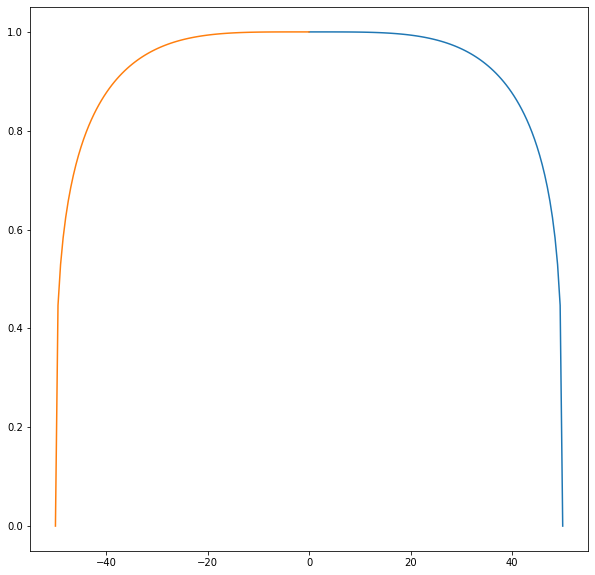

In [ ]:
def superellipse(x, n=2, a=1, b=1, size=1):
  return b * (size**n - np.abs(x/a)**n)**(1/n)

a=1
b=1/50
size = 50
n=4
x=np.linspace(0,size,100)
y=superellipse(x,n=n,a=a,b=b,size=size)
fig,ax=plt.subplots(1,1,figsize=(10,10))
ax.plot(x,y)
ax.plot(-x,y)

(0.0, 1.0)

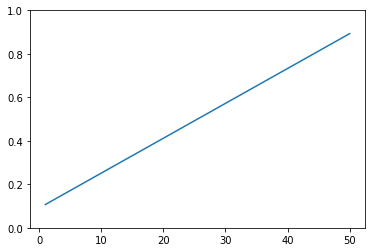

In [ ]:
x = np.arange(1,MOST_VOTES)
#y = pop_multiplier(np.ones(MOST_VOTES), x, MOST_VOTES, PopWeight)
len(np.ones(MOST_VOTES))


n=90
theta= np.linspace(-1/MOST_VOTES,1/MOST_VOTES,100)[n]
b=(1-MOST_VOTES*theta)/2
x=np.arange(1,MOST_VOTES)
y=x*theta + b
plt.plot(x,y)
plt.ylim(0,1)

to do:

rym print / dataframe switch option
reset button

In [ ]:
#@markdown Interactive Chart

import ipywidgets as widgets
import matplotlib.pyplot as plt
from IPython.display import display

def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

def superellipse(x, n=2, a=1, b=1, size=1):
  return b * (size**n - np.abs(x/a)**n)**(1/n)

def hover(hover_color='silver'):
    return dict(selector="tr:hover", props=[("background-color", "%s" % hover_color)])

def alternate_row_colors(background_color='gainsboro'):
  return dict(selector='tr:nth-child(even)',props=[("background-color", "%s" % background_color)])

styles = [hover()]

def style_df(a):
    a_styled = a.style.set_properties(**{'text-align': 'center'})#.hide_index()
    a_styled = a_styled.format("{:.1f}",subset=['Score'])
    # #styles = [alternate_row_colors(),hover()]   
    #styles = [hover()] 
    #a_styled.set_table_styles(styles)

    return a_styled

def exp_pop_multiplier(counts, most_votes, pop_weight):

  if pop_weight == 0: return np.ones(len(counts))

  multipliers = 1 + most_votes * np.exp(-(counts-1)**2 / (2*(pop_weight*most_votes)**2))
  multipliers /= 1 + most_votes

  return multipliers

def linear_pop_multiplier(counts, most_votes, pop_weight):
  theta = np.linspace(-1/most_votes, 1/most_votes, 201)[pop_weight]
  b = (1-theta*most_votes)/2
  multipliers = theta * counts + b
  return 2*multipliers

def squircle_pop_multiplier(counts, most_votes, pop_weight):
  if pop_weight >= 0: 
    counts = counts + 2 * (most_votes//2 - counts) + 2
  n = np.linspace(1, 0.1, 101)[np.abs(pop_weight)]
  multipliers = superellipse(counts-1, n=n, a=1, b=1/most_votes, size=most_votes)
  return 2*multipliers

# def pop_multiplier(counts, most_votes, pop_weight):

#   if pop_weight == 0: return np.ones(len(counts))

#   multipliers = 1 + most_votes * np.exp(-(counts-1)**2 / (2*(pop_weight*most_votes)**2))
#   multipliers /= 1 + most_votes

  return multipliers

def filt(vote_matrix_multi, Results, Weight, PopWeight, Plot):

    if np.abs(PopWeight) <= 100:
      PopWeight += 100
      pop_multiplier = linear_pop_multiplier
    else:
      PopWeight -= np.sign(PopWeight)*100
      pop_multiplier = squircle_pop_multiplier

    Weight /= 10

    vote_matrix_multi = vote_matrix_multi.mask(vote_matrix_multi==-1,25.5)
    #score_matrix = vote_matrix_multi.mask(vote_matrix_multi>0,MAX_LENGTH-vote_matrix_multi+1) # Borda
    #score_matrix = vote_matrix_multi.mask(vote_matrix_multi>0, (MAX_LENGTH-1)*np.exp(-(vote_matrix_multi-1)**2 / (2*Weight**2))) # Exponential
    score_matrix = vote_matrix_multi.mask(vote_matrix_multi>0, 1+superellipse(vote_matrix_multi-1,n=Weight,a=1,b=1,size=MAX_LENGTH)) # Squircle
    results = pd.DataFrame(index=vote_matrix_multi.index)
    results["Score"] = score_matrix.sum(axis=1)
    
    results["Score"] *= pop_multiplier(COUNTS, MOST_VOTES, PopWeight)
      # results["Score"] *= 1 + MOST_VOTES * np.exp(-(COUNTS-1)**2 / (2*(PopWeight*MOST_VOTES)**2))
      # results["Score"] /= 1 + MOST_VOTES

    results["Votes"] = COUNTS
    results["Rank"] = results["Score"].rank(ascending=False,method='min').astype(int)

    if Plot:

      fig, ax = plt.subplots(1,2,figsize=(15,5))

      # Points
      x = np.arange(1,51)
      #y = MAX_LENGTH*gaussian(x, 0, Weight)
      y = superellipse(x-1,n=Weight,a=1,b=1,size=MAX_LENGTH)
      ax[0].scatter(x, y)
      ax[0].plot([1,MAX_LENGTH],[MAX_LENGTH,1], label="Borda", ls="--",c="darkgrey")
      ax[0].set_xlabel("List Rank")
      ax[0].set_ylabel("Points")
      ax[0].set_ylim(0,1.1*MAX_LENGTH)
      ax[0].legend()

      # Popularity Weighting
      x = np.arange(1,MOST_VOTES+1)
      y = pop_multiplier(x, MOST_VOTES, PopWeight)
      ax[1].scatter(x,y)
      ax[1].set_xlabel("Film Votes")
      ax[1].set_ylabel("Popularity Multiplier")
      ax[1].set_ylim(0,2.1)

      plt.show()

    return results[["Rank","Score","Votes"]].sort_values(by="Rank")[:Results]

def display_df(Results,Weight,PopWeight,Plot):

    a = filt(vote_matrix_multi, Results, Weight,PopWeight, Plot)
    a_styled = style_df(a)
    #print('Entries:', len(a))
    display(a_styled)

MAX_LENGTH = 50 # Maximum list length
MOST_VOTES = max(cdf["Votes"]) # Number of votes of most voted entry
COUNTS = vote_matrix_multi.astype(bool).sum(axis=1)

# Widgets
layout={'width': '350px'}
res_w = widgets.IntSlider(min=10, max=len(vote_matrix_multi), step=1,layout=layout,value=20,description='Results:')
pop_weight = widgets.IntSlider(min=-200, max=200, step=1,layout=layout,value=0,description='Pop Weight:')
top_weight = widgets.IntSlider(min=1, max=50, step=1,layout=layout,value=10,description='Top Weight:')
plot_w = widgets.Checkbox(value=True,description='Illustrate Point Distribution')
ws = [res_w,plot_w,top_weight,pop_weight]

out = widgets.interactive_output(display_df,{'Results':res_w,'Weight':top_weight,'PopWeight':pop_weight,"Plot":plot_w})
ui = widgets.GridBox(ws, layout=widgets.Layout(grid_template_columns="repeat(2, 400px)"))

display(ui, out)

GridBox(children=(IntSlider(value=20, description='Results:', layout=Layout(width='350px'), max=1028, min=10),…

Output()

In [ ]:

import ipywidgets as widgets
from IPython.display import display

df['First Air Date'].replace('','00000',inplace=True)
df['Last Air Date'].replace('','00000',inplace=True)
df['First Air Date'].replace(np.nan,'00000',inplace=True)
df['Last Air Date'].replace(np.nan,'00000',inplace=True)

df['Episodes'].replace('',0,inplace=True)
df['Episodes'].replace(np.nan,0,inplace=True)

df=df.astype({'Episodes':'int','Votes':'int','Rank':'int','Esoteric Rank':'int','Episodes':'int'})

viewdf = df.dropna().drop(['AniListID','TMDbID','IMGID'],axis=1)
viewdf = viewdf.loc[viewdf['Votes']>0]

unique_studios = viewdf.groupby('Studio')['Studio'].size().index.values.tolist()
unique_source = ['All', *viewdf.groupby('Source')['Source'].size().index.values.tolist()]
if '' in unique_source:
  unique_source.remove('')

genredf = viewdf['Genres']
genredf = genredf.str.split(', ')
genredf = genredf.explode()
unique_genres = genredf.groupby(genredf).size().index.values.tolist()

def hover(hover_color='silver'):
    return dict(selector="tr:hover", props=[("background-color", "%s" % hover_color)])

def alternate_row_colors(background_color='gainsboro'):
  return dict(selector='tr:nth-child(even)',props=[("background-color", "%s" % background_color)])

styles = [hover()]

def style_df(a):
    a_styled = a.style.set_properties(**{'text-align': 'center'})#.hide_index()
    a_styled = a_styled.format("{:.1f}",subset=['Esoteric Score','Score'])
    #styles = [alternate_row_colors(),hover()]   
    styles = [hover()] 
    a_styled.set_table_styles(styles)

    return a_styled

def filt(a, Results, Year, Episodes, ExGenres, InGenres, Studio, Source, Sort, Ascending):
    
    a=viewdf[viewdf['Episodes'].notna()]

    if ExGenres != '':
        a = a[a['Genres'].str.find(ExGenres) < 0]
        
    if InGenres != '':
        a = a[a['Genres'].str.find(InGenres) > -1]

    # If slider max, include series with larger episode counts as well
    Episodes = list(Episodes)
    Episodes[1] = 1000 if Episodes[1] == 150 else Episodes[1]        
    a=a[(a['Episodes'] < Episodes[1]) & (a['Episodes'] > Episodes[0])]
    
    # Also include missing release dates
    a=a[(a['Last Air Date'].str[:4].astype(int) <= Year[1]) | (a['Last Air Date'] == '00000')]
    a=a[(a['First Air Date'].str[:4].astype(int) >= Year[0]) | (a['First Air Date'] == '00000')]
    
    if Studio != '':
        a=a[a['Studio'] == Studio]
       
    if Source not in ['All','']:
        a=a[a['Source'] == Source]
        
    if Sort != '':
        if Sort == 'Esoteric':
            a=a.sort_values(by=['Esoteric Rank'],ascending=Ascending)
        elif Sort == 'Title':
            a=a.sort_index(ascending=Ascending)
        else:
            a=a.sort_values(by=[Sort],ascending=Ascending)

    return a[:Results]

def display_df(Results, Year, Episodes, ExGenres, InGenres, Studio, Source, Sort, Ascending):

    a = filt(df, Results, Year, Episodes, ExGenres, InGenres, Studio, Source, Sort, Ascending)

    a_styled = style_df(a)
    print('Entries:', len(a))
    display(a_styled)

# Widgets

layout={'width': '350px'}

res_w = widgets.IntSlider(min=10, max=500, step=1,layout=layout,value=20,description='Results:')
year_w = widgets.IntRangeSlider(min=1970, max=2020, step=1,layout=layout,value=[1970,2020],description='Year:')
episodes_w = widgets.IntRangeSlider(min=2, max=150, step=1,layout=layout,value=[2,150],description='Episodes:')
studio_w = widgets.Combobox(options=unique_studios,layout=layout,placeholder='Studio',description='Studio:')
source_w = widgets.Dropdown(options=unique_source,layout=layout,value='All',description='Source:')
sort_w = widgets.Dropdown(options=['Rank','Esoteric','Episodes','Title','Votes','Studio','First Air Date','Last Air Date'],layout=layout,value='Rank',description='Sort:')
check_w = widgets.Checkbox(value=True,description='Ascending')

exgenres_w = widgets.Combobox(layout=layout,options=unique_genres,placeholder='Exclude Genre',description='Excl. Genre:')
ingenres_w = widgets.Combobox(layout=layout,options=unique_genres,placeholder='Include Genre',description='Incl. Genre:')

ws = [res_w,year_w,episodes_w,exgenres_w,studio_w,ingenres_w,sort_w,source_w,check_w]

out = widgets.interactive_output(display_df,{'Results':res_w,'Year':year_w,'Episodes':episodes_w,'ExGenres':exgenres_w,'InGenres':ingenres_w,'Studio':studio_w,'Ascending':check_w,'Sort':sort_w,'Source':source_w})
ui = widgets.GridBox(ws, layout=widgets.Layout(grid_template_columns="repeat(2, 400px)"))

display(ui, out)

# Adjust the output height to 2000px.
#from IPython import display
#display.Javascript("google.colab.output.setIframeHeight('2000px');")